# Faster Polynomial Features

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Polynomial Features

The current implementation of [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) (0.20.2) implements a term by term product for each pair $X_i, X_j$ of features where $ i \leqslant j$ which is not the most efficient way to do it.

In [3]:
import numpy.random
X = numpy.random.random((100, 5))

In [4]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [5]:
%timeit poly.transform(X)

670 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The class [ExtendedFeatures](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/mlinsights/mlmodel/extended_features.html) implements a different way to compute the polynomial features as it tries to reduce the number of calls to numpy by using broacasted vector multplications.

In [6]:
from mlinsights.mlmodel import ExtendedFeatures
ext = ExtendedFeatures(poly_degree=2)
Xpoly = ext.fit_transform(X)
ext.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [7]:
%timeit ext.transform(X)

75.7 µs ± 9.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Comparison with 5 features

In [8]:
from cpyquickhelper.numbers import measure_time

In [9]:
res = []
for n in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 5))
    r1 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=2, number=30)
    r2 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=2, number=30)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["size"] = n
    r2["size"] = n
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,number,repeat,size
23,0.605564,240,0.025304,0.630868,0.580260,ext,30,2,50000
24,1.841894,240,0.029580,1.871474,1.812315,poly,30,2,100000
25,1.317821,240,0.002342,1.320163,1.315479,ext,30,2,100000
26,4.827823,240,0.275791,5.103614,4.552033,poly,30,2,200000
27,2.506489,240,0.008040,2.514529,2.498448,ext,30,2,200000


In [10]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,poly
size,,
10,0.004351,0.011795
20,0.004101,0.007698
50,0.004352,0.007831
100,0.004989,0.010264
200,0.005617,0.009466


Text(0.5, 0, 'number of observations')

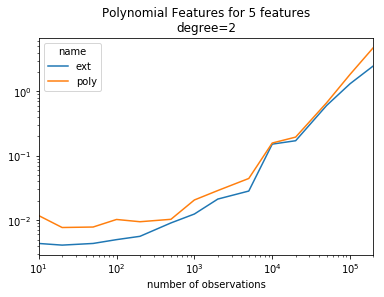

In [11]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree=2")
ax.set_xlabel("number of observations")

The gain is mostly visible for small dimensions.

## Comparison with 1000 observations

In this experiment, the number of observations is fixed to 1000 but the number of features varies.

In [12]:
res = []
for n in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 40, 50]:
    X = numpy.random.random((1000, n))
    r1 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30)
    r2 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["nfeat"] = n
    r2["nfeat"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,nfeat,number,numf,repeat
21,0.074758,240,0.000997,0.076627,0.073863,ext,20,30,231,5
22,0.642869,240,0.020800,0.681936,0.620076,poly,40,30,861,5
23,0.269395,240,0.004042,0.276028,0.264767,ext,40,30,861,5
24,0.984982,240,0.004936,0.994451,0.979932,poly,50,30,1326,5
25,0.413509,240,0.004018,0.419934,0.409251,ext,50,30,1326,5


In [13]:
piv = df.pivot("nfeat", "name", "average")
piv[:5]

name,ext,poly
nfeat,,
2,0.005297,0.011749
3,0.006570,0.009648
4,0.009826,0.012617
5,0.011999,0.017116
6,0.010219,0.020280


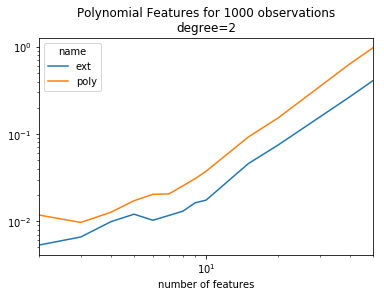

In [14]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\ndegree=2")
ax.set_xlabel("number of features");

It is faster by a short amount of time.

## Comparison for different degrees

In this experiment, the number of observations and features is fixed, the degree increases.

In [15]:
res = []
for n in [2, 3, 4, 5, 6, 7, 8]:
    X = numpy.random.random((1000, 4))
    poly = PolynomialFeatures(degree=n)
    ext = ExtendedFeatures(poly_degree=n)
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30)
    r2 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["degree"] = n
    r2["degree"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,degree,deviation,max_exec,min_exec,name,number,numf,repeat
9,0.079539,240,6,0.001258,0.081451,0.078235,ext,30,210,5
10,0.256072,240,7,0.001661,0.257907,0.253251,poly,30,330,5
11,0.125454,240,7,0.002739,0.130682,0.122884,ext,30,330,5
12,0.398759,240,8,0.004418,0.404963,0.393494,poly,30,495,5
13,0.184939,240,8,0.002957,0.188949,0.180515,ext,30,495,5


In [16]:
piv = df.pivot("degree", "name", "average")
piv[:5]

name,ext,poly
degree,,
2,0.006766,0.011471
3,0.012716,0.021234
4,0.020421,0.040854
5,0.033217,0.074457
6,0.079539,0.157700


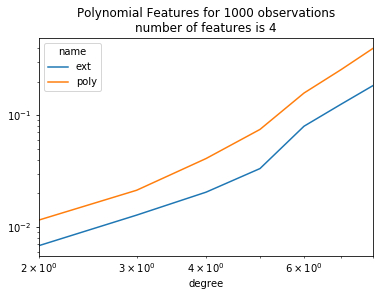

In [17]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\nnumber of features is 4")
ax.set_xlabel("degree");